In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import zipfile
import sys
import random
import os
from PIL import Image
import pickle#to save the weights of the model
import time
import shutil #to create a zip file

# from tensorflow.keras.applications import VGG19, ResNet50, MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization
# tf.keras.regularizers
from tensorflow.keras import regularizers
from tensorflow.keras import Model, Input 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.image import resize_with_crop_or_pad
from tensorflow import cast, expand_dims, int32, convert_to_tensor, float32
from tensorflow.keras.utils import plot_model 
from tensorflow.keras.preprocessing.image import load_img
# from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess #preprocess the images before passing to the model to be as eeach model expects
# from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess
# from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess #rescale images from [0,255] to [-1,1]
from tensorflow.keras import metrics 
from tensorflow.io import read_file
from tensorflow.compat.v1.image import decode_jpeg
from numpy import squeeze
from tensorflow.keras.models import load_model
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
#### Determine fixed variables for model

(img_width, img_height) = (224,224) 
batch_size = 64 # small batch size because the datasset in small

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [5]:
train_path = '/kaggle/input/adult-child-v3-web-results/Adult_Child_v3 web_results/train'
validation_path = '/kaggle/input/adult-child-v3-web-results/Adult_Child_v3 web_results/val'
test_path = '/kaggle/input/adult-child-v3-web-results/Adult_Child_v3 web_results/test'

In [6]:
#Load the model from TF hub
pose_model = hub.load('https://tfhub.dev/google/movenet/singlepose/thunder/4') #Thunder is the more accurate version but also larger and slower than Lightning
movenet = pose_model.signatures['serving_default']

In [7]:
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
]

In [8]:
def print_parameters_count(model_):
    import tensorflow.keras.backend as K
    trainable_count = np.sum([K.count_params(w) for w in model_.trainable_weights])
    non_trainable_count = np.sum([K.count_params(w) for w in model_.non_trainable_weights])

    print('Total params: {:,}'.format(trainable_count + non_trainable_count))
    print('Trainable params: {:,}'.format(trainable_count))
    print('Non-trainable params: {:,}'.format(non_trainable_count))

def draw_keypoints(image, keypoints, confidence_threshold):
    # Get the height, width, and channels of the input image
    height, width, channels = image.shape
    # Scale the keypoints to match the size of the input image
    _shaped_keypoints = np.squeeze(np.multiply(keypoints, [height,width,1]))
    
    for kp in _shaped_keypoints:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(image, (int(kx), int(ky)), 4, (0,255,0), -1)


EDGES = {
    (0, 1): 'm',    (0, 2): 'c',    (1, 3): 'm',    (2, 4): 'c',
    (0, 5): 'm',    (0, 6): 'c',    (5, 7): 'm',    (7, 9): 'm',
    (6, 8): 'c',    (8, 10): 'c',    (5, 6): 'y',    (5, 11): 'm',
    (6, 12): 'c',    (11, 12): 'y',    (11, 13): 'm',    (13, 15): 'm',
    (12, 14): 'c',    (14, 16): 'c'}

def draw_connections(image, keypoints, edges, confidence_threshold):
    # Get the height, width, and channels of the input image
    height,  width, c = image.shape
    # Scale the keypoints to match the size of the input image
    _shaped_keypoints = np.squeeze(np.multiply(keypoints, [height, width,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = _shaped_keypoints[p1]
        y2, x2, c2 = _shaped_keypoints[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(image, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)


def print_performance_report(model, test_generator):
    """takes as input a model and DirectoryIterator
    and prints the classification report and the Confusion matrix"""
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes
    class_labels=list(test_generator.class_indices.keys())

    print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_labels))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))

def get_size(model_path):
        # Get the size of the saved model file in MB
    file_size = os.path.getsize(model_path) / (1024 * 1024)
    return file_size
def delete_files_inside(folder):
    for file in os.listdir(folder):
        os.remove(os.path.join(folder,file)) 

    #Confusion_matrix
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions>0.5 )
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Adults Detected (True Negatives): ', cm[0][0])
    print('Child Incorrectly Detected (False Positives): ', cm[0][1])
    print('Child Missed (False Negatives): ', cm[1][0])
    print('Child Detected (True Positives): ', cm[1][1])
    
    
def zip_delete(model_name, path):
    """makes a ziped folder of all the results
    and deleted all the initial folder to make it easier to load the data in /kaggle/working"""
    shutil.make_archive(model_name, 'zip', path)
    delete_files_inside(path)
    os.rmdir(path)
    
def delete_folder_contents(folder_path):
    for root, dirs, files in os.walk(folder_path, topdown=False):
        for file in files:
            os.remove(os.path.join(root, file))
        for dir in dirs:
            os.rmdir(os.path.join(root, dir))
    os.rmdir(folder_path)
    

def plot_save_results(model_, model_name, fine_tuning,with_keypoints, num_epcohs, batch_size, history, save=True, loaded=False):
    #create folder for this model

    dir_name = model_name
    model_detailed_name = f"{model_name}__{with_keypoints}__{fine_tuning}__{num_epcohs}epcohs__{batch_size}batch"
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    mpl.rcParams['figure.figsize'] = (12, 10)
    
    if loaded:
        epochs = range(1, len(history['loss'])+1)
        history_dict = history
    else:
        epochs = range(1, len(history.history['loss'])+1)
        history_dict = history.history
    metrics = [ 'loss','accuracy',  'precision', 'recall','tp', 'fp', 'tn', 'fn',]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(len(metrics)//2,2,n +1)
        plt.plot(epochs, history_dict[metric], color=colors[0], label='Train')
        plt.plot(epochs, history_dict['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1.1])
        elif metric=='tp' or metric=='fp' or metric=='tn' or metric=='fn':
            plt.ylim([1,np.max(history_dict[metric]) *  1.1 ])
        else:
            plt.ylim([0,1.1])
        
        plt.legend()
    if save:    
        plt.savefig(f"{dir_name}/{model_detailed_name}_{metric}.png")
        # Save the entire model to a file
        model_.save(f"{dir_name}/{model_detailed_name}.h5")

        # Save history to a file
        with open(f"{dir_name}/history_{model_detailed_name}.pickle", "wb") as f:
            pickle.dump(history.history, f)

In [9]:
# def create_base_VGG19():
#     return VGG19(weights='imagenet',input_shape=(224, 224, 3),include_top=False)
# def create_base_ResNet():
#     return  ResNet50(weights='imagenet', input_shape=(224, 224, 3),include_top=False)
def create_base_MobileNetV2():
    return  MobileNetV2(weights='imagenet', input_shape=(224, 224,3),  include_top=False)

In [10]:
# Define a preprocessing function to be applied to each image
def preprocess_image_add_pose_keypoints(image_, pose_model=movenet, image_output_shape=(224,224), confidence_threshold=0.15, circle_thickness=3, line_thickness=2 ):
    #check if image is corrupted
    """The function reads a PIL image, converts to numpy array, resize to be able to be processed by the pose model,
    then the pose estimation keypoints are added, then reshaped as the NN model expects.
    source of image transformations: https://tfhub.dev/google/movenet/singlepose/lightning/4"""
#     image_ = cast(resize_with_crop_or_pad(expand_dims(image_, axis=0), 256, 256), dtype=int32)
    image_ = tf.convert_to_tensor(image_, dtype=tf.float32)

    image_ = tf.expand_dims(image_, axis=0)
    # Resize and pad the image to keep the aspect ratio and fit the expected size.
    image_ = tf.cast(tf.image.resize_with_crop_or_pad(image_, 256, 256), dtype=tf.int32)
    if image_.shape[1] != 256 or image_.shape[2] != 256:
        return None
    outputs = pose_model(image_)
    # Reshape the image from (1, 256, 256, 3) to (256, 256, 3) and return an nd-array
    image_ = np.squeeze(image_)
    # Output is a [1, 1, 17, 3] tensor. to numpy array then take the points and reshape
    keypoints_with_scores = outputs['output_0'].numpy()[0,0,:,:51].reshape((17,3))
    #transform to numpy array to add the points and lines since tensorflow does not do that easily
    (height,width) = (image_.shape[0],image_.shape[1])
    #multiply x by height, y by weight (and score by 1)to get the real position on the image
    shaped_keypoints =  np.multiply(keypoints_with_scores, [height,width,1])     
    #########################################################################################################3
    for kp in shaped_keypoints:
        ky, kx, kp_conf = kp
        #print(kp)
        if kp_conf > confidence_threshold:
            cv2.circle(image_, (int(kx), int(ky)), 2, (0,0,0), 1)
    #draw_keypoints(image_array, outputs, confidence_threshold=0.3)
    for edge, color in EDGES.items():
        p1, p2 = edge
        y1, x1, c1 = shaped_keypoints[p1]
        y2, x2, c2 = shaped_keypoints[p2]
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(image_, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,0), 2)
 
    #Resize iamge to fit the model of training
    #should change the output shape of the ouput to be fit to the pretrained mode
    image_ = image_.astype(np.float32)#image does not change
    #When the image is of type float, plt expects it to be in rannge[0,1]
    #ImageDataGenerator class expects a NumPy array as input,
    image_  = cv2.resize(image_,dsize=(image_output_shape[0], image_output_shape[1]))
#     tensor = tf.convert_to_tensor(x_np)

    return image_


def count_conv2d_layers(model):
    count = 0
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            count += 1
    return count


def count_total_layers(model):
    count = len(model.layers)
    return count

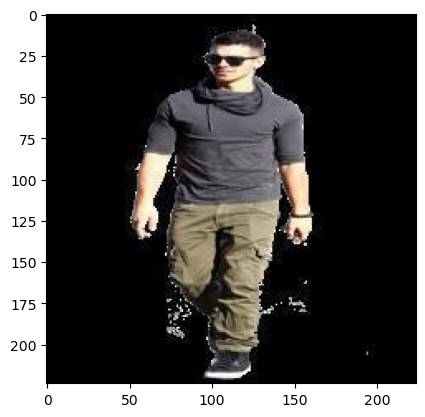

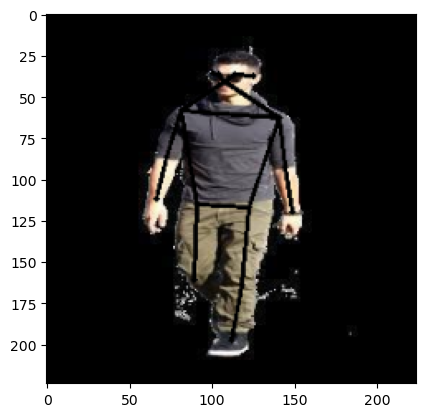

In [15]:
folder_path = '/kaggle/input/adult-child-v3-web-results/Adult_Child_v3 web_results/train/Adult'
images = [f for f in os.listdir(folder_path) ]
image = random.choice(images)
image_path = os.path.join(folder_path , image)

# Read the image
img = cv2.imread(image_path)

# Display the original image
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

# Apply the preprocess function
processed_img = preprocess_image_add_pose_keypoints(img)
image = cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB)

# Display the processed image
plt.imshow(image/255)
plt.show()

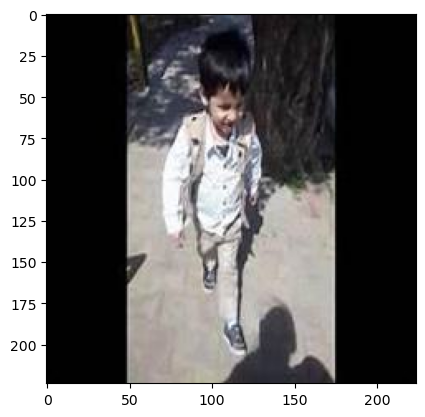

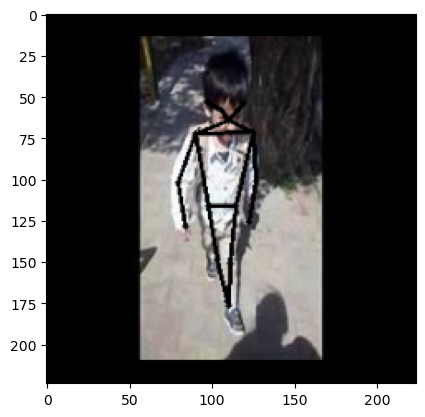

In [12]:
folder_path = '/kaggle/input/adult-child-v3-web-results/Adult_Child_v3 web_results/train/Child'
images = [f for f in os.listdir(folder_path) ]
image = random.choice(images)
image_path = os.path.join(folder_path , image)

# Read the image
img = cv2.imread(image_path)

# Display the original image
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

# Apply the preprocess function
processed_img = preprocess_image_add_pose_keypoints(img)
image = cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB)

# Display the processed image
plt.imshow(image/255)
plt.show()

In [13]:
############################################################################################################################################
# Create a data generator to load and augment the training data
#Removed rescale from Image data generators, since Using pre
train_datagen_without_preprocessing = ImageDataGenerator(  
    rescale=1.0/255,  #If using the pre processing fn of the pre trainde models, no need to rescale, and should add featurewise_center=False if so.
    featurewise_center=False, # if using the pre processing of the pre trained models, no need to make featurewise center, and if not false, should fit it before use
    rotation_range=20,  # randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # randomly shift images horizontally by up to 20% of the image width
    height_shift_range=0.2,  # randomly shift images vertically by up to 20% of the image height
    shear_range=0.2,  # randomly shear images by up to 20%
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False,  # do not randomly flip images vertically
    fill_mode='nearest'
)

train_generator_without_preprocessing = train_datagen_without_preprocessing.flow_from_directory(
    train_path,
    target_size=(img_width, img_height), 
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)
# Create a data generator to load the validation data
val_datagen_without_preprocessing = ImageDataGenerator( rescale=1.0/255,
                                                       featurewise_center=False)

val_generator_without_preprocessing = val_datagen_without_preprocessing.flow_from_directory(
    validation_path,
    target_size= (img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
shuffle=False)

#######################################################################################################################################
# Create a data generator to accept the trainign data with the preprocessing function
train_datagen_with_preprocessing = ImageDataGenerator(
    rescale=1.0/255,
    featurewise_center=False,
     rotation_range=20,  # randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # randomly shift images horizontally by up to 20% of the image width
    height_shift_range=0.2,  # randomly shift images vertically by up to 20% of the image height
    shear_range=0.2,  # randomly shear images by up to 20%
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False,  # do not randomly flip images vertically
    fill_mode='nearest',  # fill any missing pixels with the nearest value
    #preprocessing_function=preprocess_image_add_pose_keypoints  # apply the preprocessing function
    preprocessing_function=lambda x: preprocess_image_add_pose_keypoints(x, movenet,
                                                                         image_output_shape=(img_width, img_height),
                                                                         confidence_threshold= 0.05)
)

train_generator_with_preprocessing = train_datagen_with_preprocessing.flow_from_directory(
    train_path,
    target_size=(img_width, img_height), 
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


# Create a data generator to load the validation data with the preprocessing function
val_datagen_with_preprocessing = ImageDataGenerator( 
    rescale=1.0/255,
    featurewise_center=False,
    #preprocessing_function=preprocess_image_add_pose_keypoints  # apply the preprocessing function
    preprocessing_function=lambda x: preprocess_image_add_pose_keypoints(x, movenet, 
                                                      image_output_shape=(img_width, img_height),confidence_threshold=0.05)
)

val_generator_with_preprocessing = val_datagen_with_preprocessing.flow_from_directory(
    
    validation_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

#######################################################################################################################################
test_datagen_without_preprocessing = ImageDataGenerator( rescale=1.0/255,
                                                        featurewise_center=False,)

#Load the training data
test_generator_without_preprocessing = test_datagen_without_preprocessing.flow_from_directory(
    test_path,
    target_size=(img_width, img_height), 
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
###################################
# Create a data generator to accept the trainign data with the preprocessing function
test_datagen_with_preprocessing = ImageDataGenerator(rescale=1.0/255,
                                                     featurewise_center=False,
    #preprocessing_function=preprocess_image_add_pose_keypoints  # apply the preprocessing function
    preprocessing_function=lambda x: preprocess_image_add_pose_keypoints(x, movenet, 
                                                      image_output_shape=(img_width, img_height),confidence_threshold= 0.05)
)

# Load the training data
test_generator_with_preprocessing = test_datagen_with_preprocessing.flow_from_directory(
    test_path,
    target_size=(img_width, img_height), 
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 9336 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 9336 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 1161 images belonging to 2 classes.
Found 1161 images belonging to 2 classes.


# model_0

## Without Pose Estimation key points

In [16]:
train_generator = train_generator_without_preprocessing
val_generator = val_generator_without_preprocessing
test_generator = test_generator_without_preprocessing
# preprocess_fn = mobilenet_preprocess

neurons_final = 32
# base_model = create_base_MobileNetV2()
# fine_tune_limit = len(base_model.layers) - int(0.1*len(base_model.layers))
model_name= 'model_0'
fine_tuning = 'before_tuning'
keypoints_added = 'without_keypoints'
epochs = 40
lr_1 = 1e-3
lr_2 = 1e-5
print("Done")


Done


In [17]:
#Input shape
input_shape = (224, 224, 3)  # Assuming input images are RGB with size 32x32

# Input Layer
input_layer = Input(shape=input_shape)

# Block 1
x = Conv2D(32, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(0.01))(input_layer)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

# Block 2
x = Conv2D(32, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)

x = GlobalAveragePooling2D()(x)
x = Dense(neurons_final, activation='relu')(x)
x = Dropout(0.5)(x)
outputs =  Dense(1, activation='sigmoid')(x)
model_0 = Model(input_layer, outputs)
print("Model Summary: " , model_0.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0     

In [18]:
counter = Counter(train_generator.classes)
print(str(counter.items())+"\n") # dict_items([(0, 1648), (1, 3614)])

dict_items([(0, 4337), (1, 4999)])



In [19]:
Adult = 4337
Child = 4999
total = Adult + Child
weight_for_Adult =   (total / Adult) 
weight_for_Child =   (total /Child)
weight_for_Adult /= (weight_for_Adult +  weight_for_Child)
weight_for_Child /= (weight_for_Adult +  weight_for_Child)

class_weight = {0: weight_for_Adult, 1: weight_for_Child}
print('Class Weights: ', class_weight)

Class Weights:  {0: 0.5354541559554413, 1: 0.7771752017284356}


In [27]:
call_backs = [EarlyStopping(monitor='val_loss', patience=6),
              ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)]

model_0.compile(optimizer=Adam(learning_rate=lr_1), loss= 'binary_crossentropy', metrics=METRICS)

steps_per_epoch = train_generator.n // batch_size  
validation_steps = val_generator.n // batch_size
print("Training Started\n")   
#############################################################################
history = model_0.fit(train_generator,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    callbacks=call_backs,
                    validation_data=val_generator,
                     class_weight=class_weight)
print("Training Finished\n")
###############################################################################

Training Started

Epoch 1/40
145/145 [==============================] - 188s 1s/step - loss: 0.8332 - tp: 3835.0000 - fp: 2391.0000 - tn: 1897.0000 - fn: 1149.0000 - accuracy: 0.6182 - precision: 0.6160 - recall: 0.7695 - val_loss: 1.0168 - val_tp: 4.0000 - val_fp: 144.0000 - val_tn: 376.0000 - val_fn: 628.0000 - val_accuracy: 0.3299 - val_precision: 0.0270 - val_recall: 0.0063 - lr: 0.0010
Epoch 2/40
145/145 [==============================] - 138s 952ms/step - loss: 0.5478 - tp: 4179.0000 - fp: 1623.0000 - tn: 2650.0000 - fn: 820.0000 - accuracy: 0.7365 - precision: 0.7203 - recall: 0.8360 - val_loss: 0.9813 - val_tp: 100.0000 - val_fp: 247.0000 - val_tn: 273.0000 - val_fn: 532.0000 - val_accuracy: 0.3238 - val_precision: 0.2882 - val_recall: 0.1582 - lr: 0.0010
Epoch 3/40
145/145 [==============================] - 137s 944ms/step - loss: 0.4156 - tp: 4459.0000 - fp: 1164.0000 - tn: 3109.0000 - fn: 540.0000 - accuracy: 0.8162 - precision: 0.7930 - recall: 0.8920 - val_loss: 0.9853 - v

In [ ]:
# delete_folder_contents('/kaggle/working/')

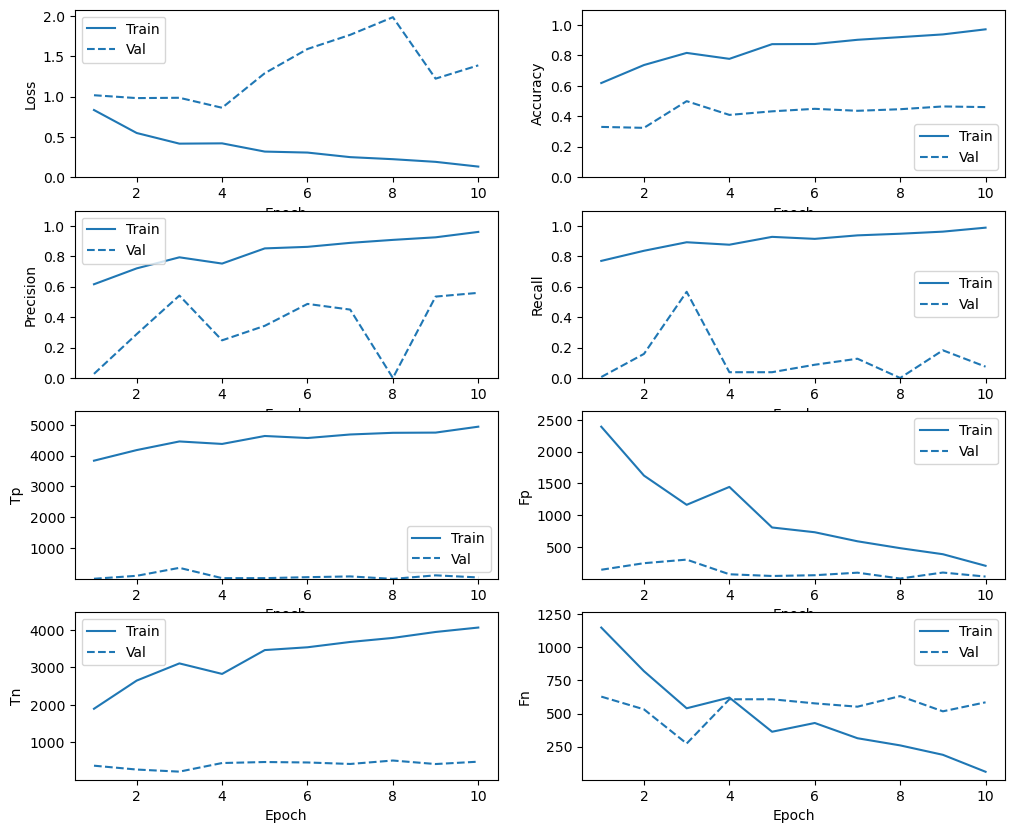

In [28]:
################################################################################################################
plot_save_results(model_0, model_name, fine_tuning, keypoints_added, epochs, batch_size, history)

# path ='/kaggle/working/{}'.format(model_name)
# name = model_name+'_'+keypoints_added+'_'+fine_tuning+'_'+str(epochs)+'epochs'
# zip_delete(name, path)

#plot_save_results(model,model_name,fine_tuning,keypoints_added,epochs_1,batch_size,history)
# model_2.save('/kaggle/working/{}.h5'.format(name))
# saved_model_before_wihoutKPts_path = '/kaggle/working/{}.h5'.format(name)
# print(saved_model_before_wihoutKPts_path)

In [29]:
###########################################################################################################
print("\n\nEvaluation of test Data Generator:\n\n")
# Evaluate the accuracy of the MobileNet_model on the test dataset using the `evaluate` method
test_generator.reset()
model_0.evaluate(test_generator)



Evaluation of test Data Generator:


19/19 [==============================] - 10s 544ms/step - loss: 1.4474 - tp: 54.0000 - fp: 45.0000 - tn: 447.0000 - fn: 615.0000 - accuracy: 0.4315 - precision: 0.5455 - recall: 0.0807


[1.4473598003387451,
 54.0,
 45.0,
 447.0,
 615.0,
 0.4315245449542999,
 0.5454545617103577,
 0.08071748912334442]

## With Pose Estimation key points

In [30]:
train_generator = train_generator_with_preprocessing
val_generator = val_generator_with_preprocessing
test_generator = test_generator_with_preprocessing
# preprocess_fn = mobilenet_preprocess
neurons_final = 32
# base_model = create_base_MobileNetV2()
# fine_tune_limit = len(base_model.layers) - int(0.1 * len(base_model.layers))
model_name= 'my_model_5layers'
fine_tuning = 'before_tuning'
keypoints_added = 'with_keypoints'
epochs = 40
lr_1 = 1e-3
# lr_2 = 1e-5
print("Done")

Done


In [31]:
# Define the input shape
input_shape = (224, 224, 3)  # Assuming input images are RGB with size 32x32

# Input Layer
input_layer = Input(shape=input_shape)

# Block 1
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01) )(input_layer)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

# Block 2
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)

x = GlobalAveragePooling2D()(x)
x = Dense(neurons_final, activation='relu')(x)
x = Dropout(0.5)(x)
outputs =  Dense(1, activation='sigmoid')(x)
model_0_PEK = Model(input_layer, outputs)
print("Model Summary: " , model_0_PEK.summary())


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_3 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_4 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 112, 112, 32)     0   

In [32]:
call_backs = [ EarlyStopping(monitor='val_loss', patience=6),
               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5) ]

In [33]:
call_backs = [ EarlyStopping(monitor='val_loss', patience=6),
               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5) ]

model_0_PEK.compile(optimizer=Adam(learning_rate=lr_1),loss= 'binary_crossentropy',metrics=METRICS)

# steps_per_epoch = train_generator.n // batch_size  
# validation_steps = val_generator.n // batch_size
print("Training Started\n\n")   
train_generator.reset()
val_generator.reset()
history = model_0_PEK.fit(train_generator,
                    epochs= epochs,
                    callbacks=call_backs,
                    validation_data=val_generator,
                          class_weight=class_weight)
print("Training Finished\n")

Training Started


Epoch 1/40
146/146 [==============================] - 291s 2s/step - loss: 0.7969 - tp: 3784.0000 - fp: 2711.0000 - tn: 2118.0000 - fn: 1884.0000 - accuracy: 0.5623 - precision: 0.5826 - recall: 0.6676 - val_loss: 0.8867 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 520.0000 - val_fn: 652.0000 - val_accuracy: 0.4437 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/40
146/146 [==============================] - 278s 2s/step - loss: 0.5125 - tp: 4349.0000 - fp: 2712.0000 - tn: 1625.0000 - fn: 650.0000 - accuracy: 0.6399 - precision: 0.6159 - recall: 0.8700 - val_loss: 0.8099 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 520.0000 - val_fn: 652.0000 - val_accuracy: 0.4437 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 3/40
146/146 [==============================] - 281s 2s/step - loss: 0.4392 - tp: 4175.0000 - fp: 2163.0000 - tn: 2174.0000 - fn: 824.0000 - accuracy: 0.6801 - precision: 0.6587 - recall: 0.8352 -

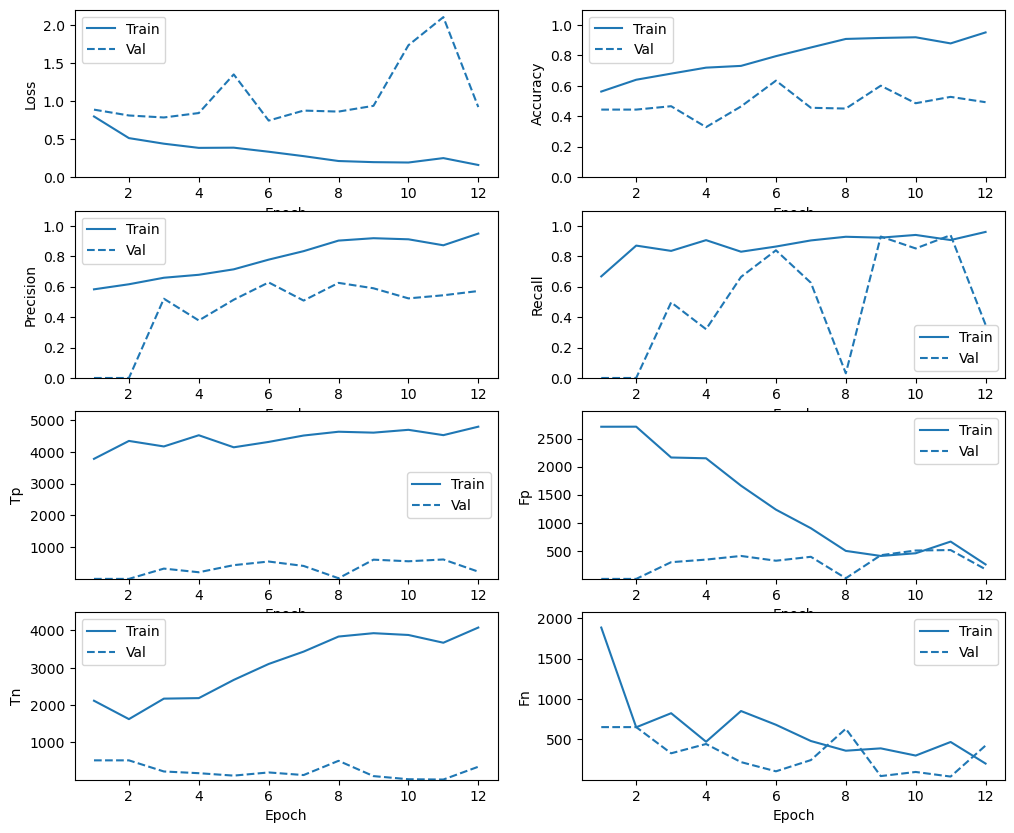

In [34]:
plot_save_results(model_0_PEK, model_name, fine_tuning, keypoints_added, epochs, batch_size, history)

# path ='/kaggle/working/{}'.format(model_name)
# name = model_name+'_'+keypoints_added+'_'+fine_tuning+'_'+str(epochs)+'epochs'
# zip_delete(name, path)

# #plot_save_results(model,model_name,fine_tuning,keypoints_added,epochs_1,batch_size,history)
# model_3.save('/kaggle/working/{}.h5'.format(name))

In [35]:
print("\n\nEvaluation of test Data Generator:\n\n")
# Evaluate the accuracy of the MobileNet_model on the test dataset using the `evaluate` method
test_generator_without_preprocessing.reset()
model_0_PEK.evaluate(test_generator)



Evaluation of test Data Generator:


19/19 [==============================] - 22s 1s/step - loss: 0.9479 - tp: 232.0000 - fp: 190.0000 - tn: 302.0000 - fn: 437.0000 - accuracy: 0.4599 - precision: 0.5498 - recall: 0.3468


[0.9479125738143921,
 232.0,
 190.0,
 302.0,
 437.0,
 0.45994833111763,
 0.549763023853302,
 0.3467862606048584]

In [37]:
print("model_0: ")
print(count_conv2d_layers(model_0))
print(count_total_layers(model_0))
print("\n")
print("model_0_PEK: ")
print(count_conv2d_layers(model_0_PEK))
print(count_total_layers(model_0_PEK))

model_0: 
3
12


model_0_PEK: 
3
12


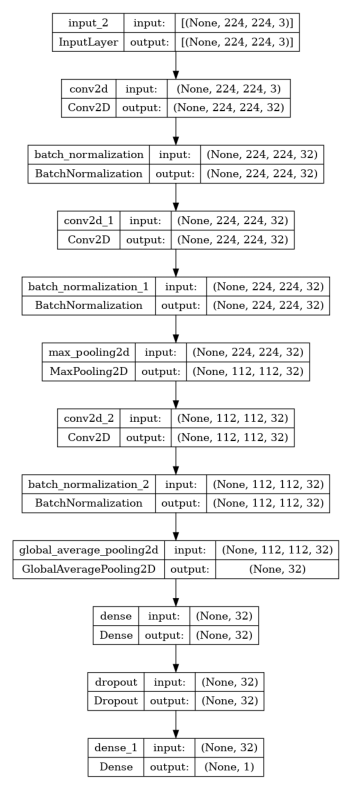

In [46]:
# Generate the model architecture plot
plot_model(model_0, to_file='model_0.png', show_shapes=True, show_layer_names=True)

# Display the image in a notebook cell
image = Image.open('model_0.png')
plt.imshow(image)
plt.axis('off')
plt.show()


# model_1

## Without Pose Estimation key points

In [38]:
train_generator = train_generator_without_preprocessing
val_generator = val_generator_without_preprocessing
test_generator = test_generator_without_preprocessing
# preprocess_fn = mobilenet_preprocess

neurons_final = 32
# base_model = create_base_MobileNetV2()
# fine_tune_limit = len(base_model.layers) - int(0.1*len(base_model.layers))
model_name= 'model_1'
fine_tuning = 'before_tuning'
keypoints_added = 'without_keypoints'
epochs = 40
lr_1 = 1e-3
lr_2 = 1e-5
print("Done")


Done


In [39]:
#Input shape
input_shape = (224, 224, 3)  # Assuming input images are RGB with size 32x32

# Input Layer
input_layer = Input(shape=input_shape)

# Block 1
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(input_layer)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

# Block 2
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)

x = GlobalAveragePooling2D()(x)
x = Dense(neurons_final, activation='relu')(x)
x = Dropout(0.5)(x)
outputs =  Dense(1, activation='sigmoid')(x)
model_1 = Model(input_layer, outputs)
print("Model Summary: " , model_1.summary())


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_6 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_7 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 32)     0   

In [40]:
counter = Counter(train_generator.classes)
print(str(counter.items())+"\n") # dict_items([(0, 1648), (1, 3614)])

dict_items([(0, 4337), (1, 4999)])



In [41]:
Adult = 4337
Child = 4999
total = Adult + Child
weight_for_Adult =   (total / Adult) 
weight_for_Child =   (total /Child)
weight_for_Adult /= (weight_for_Adult +  weight_for_Child)
weight_for_Child /= (weight_for_Adult +  weight_for_Child)

class_weight = {0: weight_for_Adult, 1: weight_for_Child}
print('Class Weights: ', class_weight)

Class Weights:  {0: 0.5354541559554413, 1: 0.7771752017284356}


In [42]:
call_backs = [EarlyStopping(monitor='val_loss', patience=6),
              ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)]

model_1.compile(optimizer=Adam(learning_rate=lr_1), loss= 'binary_crossentropy', metrics=METRICS)

steps_per_epoch = train_generator.n // batch_size  
validation_steps = val_generator.n // batch_size
print("Training Started\n")   
#############################################################################
history = model_1.fit(train_generator,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    callbacks=call_backs,
                    validation_data=val_generator,
                     class_weight=class_weight)
print("Training Finished\n") 
###############################################################################

Training Started

Epoch 1/40
145/145 [==============================] - 153s 1s/step - loss: 1.0173 - tp: 4387.0000 - fp: 2843.0000 - tn: 1922.0000 - fn: 1281.0000 - accuracy: 0.6047 - precision: 0.6068 - recall: 0.7740 - val_loss: 1.0662 - val_tp: 632.0000 - val_fp: 520.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5486 - val_precision: 0.5486 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/40
145/145 [==============================] - 135s 932ms/step - loss: 0.6209 - tp: 4282.0000 - fp: 2185.0000 - tn: 2088.0000 - fn: 717.0000 - accuracy: 0.6870 - precision: 0.6621 - recall: 0.8566 - val_loss: 0.9384 - val_tp: 382.0000 - val_fp: 455.0000 - val_tn: 65.0000 - val_fn: 250.0000 - val_accuracy: 0.3880 - val_precision: 0.4564 - val_recall: 0.6044 - lr: 0.0010
Epoch 3/40
145/145 [==============================] - 141s 969ms/step - loss: 0.4110 - tp: 4552.0000 - fp: 1260.0000 - tn: 3077.0000 - fn: 383.0000 - accuracy: 0.8228 - precision: 0.7832 - recall: 0.9224 - val_loss: 0.889

In [43]:
# delete_folder_contents('/kaggle/working/')

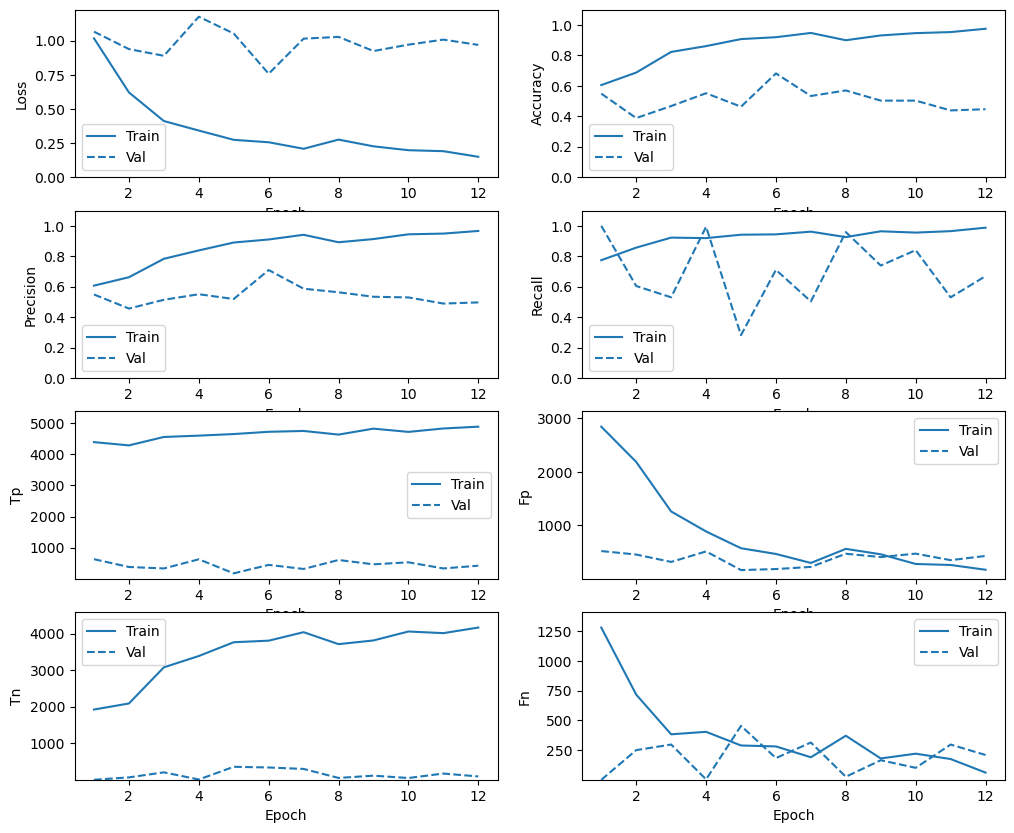

In [44]:
################################################################################################################
plot_save_results(model_1, model_name, fine_tuning, keypoints_added, epochs, batch_size, history)

# path ='/kaggle/working/{}'.format(model_name)
# name = model_name+'_'+keypoints_added+'_'+fine_tuning+'_'+str(epochs)+'epochs'
# zip_delete(name, path)

#plot_save_results(model,model_name,fine_tuning,keypoints_added,epochs_1,batch_size,history)
# model_2.save('/kaggle/working/{}.h5'.format(name))
# saved_model_before_wihoutKPts_path = '/kaggle/working/{}.h5'.format(name)
# print(saved_model_before_wihoutKPts_path)

In [45]:
###########################################################################################################
print("\n\nEvaluation of test Data Generator:\n\n")
# Evaluate the accuracy of the MobileNet_model on the test dataset using the `evaluate` method
test_generator.reset()
model_1.evaluate(test_generator)



Evaluation of test Data Generator:


19/19 [==============================] - 5s 284ms/step - loss: 0.9553 - tp: 446.0000 - fp: 422.0000 - tn: 70.0000 - fn: 223.0000 - accuracy: 0.4444 - precision: 0.5138 - recall: 0.6667


[0.9552993178367615,
 446.0,
 422.0,
 70.0,
 223.0,
 0.4444444477558136,
 0.5138248801231384,
 0.6666666865348816]

## With Pose Estimation key points

In [49]:
train_generator = train_generator_with_preprocessing
val_generator = val_generator_with_preprocessing
test_generator = test_generator_with_preprocessing
# preprocess_fn = mobilenet_preprocess
neurons_final = 32
# base_model = create_base_MobileNetV2()
# fine_tune_limit = len(base_model.layers) - int(0.1 * len(base_model.layers))
model_name= 'my_model_5layers'
fine_tuning = 'before_tuning'
keypoints_added = 'with_keypoints'
epochs = 40
lr_1 = 1e-3
# lr_2 = 1e-5
print("Done")

Done


In [50]:
# Define the input shape
input_shape = (224, 224, 3)  # Assuming input images are RGB with size 32x32

# Input Layer
input_layer = Input(shape=input_shape)

# Block 1
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(input_layer)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

# Block 2
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)

x = GlobalAveragePooling2D()(x)
x = Dense(neurons_final, activation='relu')(x)
x = Dropout(0.5)(x)
outputs =  Dense(1, activation='sigmoid')(x)
model_1_PEK = Model(input_layer, outputs)
print("Model Summary: " , model_1_PEK.summary())


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_10 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_11 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_11 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 32)     0   

In [51]:
call_backs = [ EarlyStopping(monitor='val_loss', patience=6),
               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5) ]

In [52]:
call_backs = [ EarlyStopping(monitor='val_loss', patience=6),
               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5) ]

model_1_PEK.compile(optimizer=Adam(learning_rate=lr_1),loss= 'binary_crossentropy',metrics=METRICS)

# steps_per_epoch = train_generator.n // batch_size  
# validation_steps = val_generator.n // batch_size
print("Training Started\n\n")   
train_generator.reset()
val_generator.reset()
history = model_1_PEK.fit(train_generator,
                    epochs= epochs,
                    callbacks=call_backs,
                    validation_data=val_generator,
                          class_weight=class_weight)
print("Training Finished\n")

Training Started


Epoch 1/40
146/146 [==============================] - 293s 2s/step - loss: 0.9748 - tp: 4192.0000 - fp: 2897.0000 - tn: 1932.0000 - fn: 1476.0000 - accuracy: 0.5834 - precision: 0.5913 - recall: 0.7396 - val_loss: 0.9619 - val_tp: 652.0000 - val_fp: 520.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5563 - val_precision: 0.5563 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/40
146/146 [==============================] - 282s 2s/step - loss: 0.4370 - tp: 4309.0000 - fp: 1843.0000 - tn: 2494.0000 - fn: 690.0000 - accuracy: 0.7287 - precision: 0.7004 - recall: 0.8620 - val_loss: 0.9788 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 520.0000 - val_fn: 652.0000 - val_accuracy: 0.4437 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 4/40
146/146 [==============================] - 280s 2s/step - loss: 0.4047 - tp: 4416.0000 - fp: 1895.0000 - tn: 2442.0000 - fn: 583.0000 - accuracy: 0.7346 - precision: 0.6997 - recall: 0.8834 - val_los

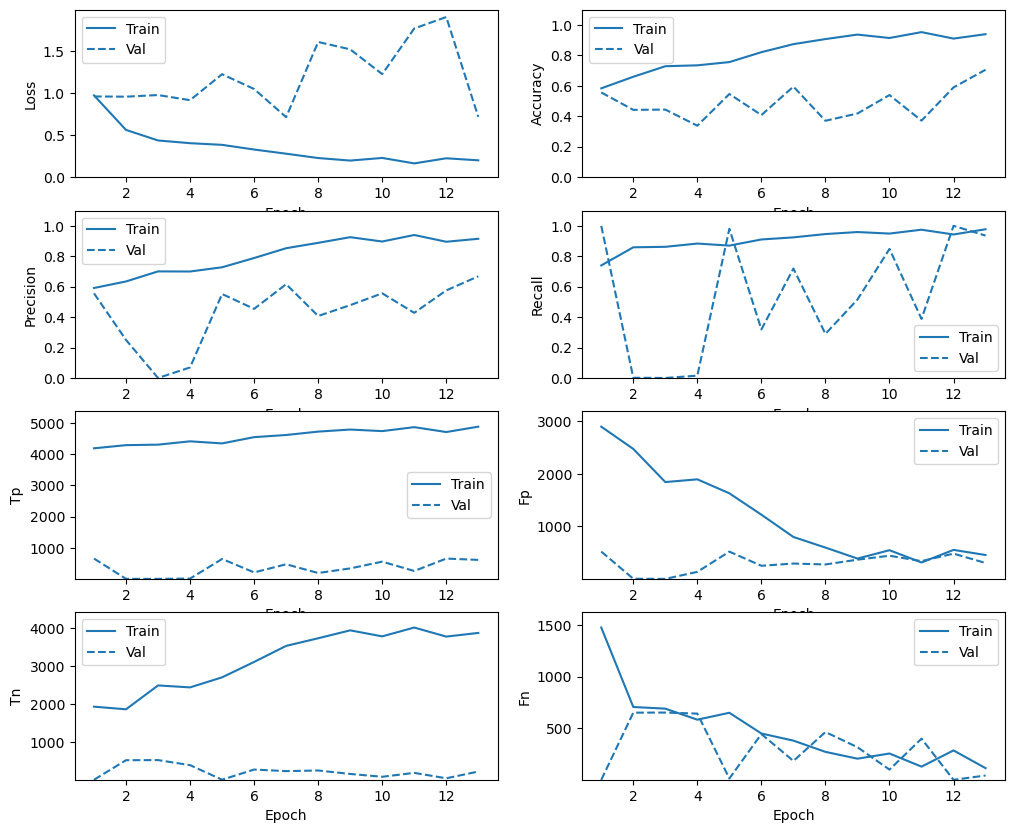

In [53]:
plot_save_results(model_1_PEK, model_name, fine_tuning, keypoints_added, epochs, batch_size, history)

# path ='/kaggle/working/{}'.format(model_name)
# name = model_name+'_'+keypoints_added+'_'+fine_tuning+'_'+str(epochs)+'epochs'
# zip_delete(name, path)

# #plot_save_results(model,model_name,fine_tuning,keypoints_added,epochs_1,batch_size,history)
# model_3.save('/kaggle/working/{}.h5'.format(name))

In [54]:
print("\n\nEvaluation of test Data Generator:\n\n")
# Evaluate the accuracy of the MobileNet_model on the test dataset using the `evaluate` method
test_generator_without_preprocessing.reset()
model_1_PEK.evaluate(test_generator)



Evaluation of test Data Generator:


19/19 [==============================] - 22s 1s/step - loss: 0.6753 - tp: 624.0000 - fp: 263.0000 - tn: 229.0000 - fn: 45.0000 - accuracy: 0.7347 - precision: 0.7035 - recall: 0.9327


[0.6752504110336304,
 624.0,
 263.0,
 229.0,
 45.0,
 0.7347114682197571,
 0.7034949064254761,
 0.9327354431152344]

In [55]:
print("model_1: ")
print(count_conv2d_layers(model_1))
print(count_total_layers(model_1))
print("\n")
print("model_1_PEK: ")
print(count_conv2d_layers(model_1_PEK))
print(count_total_layers(model_1_PEK))

model_1: 
4
14


model_1_PEK: 
4
14


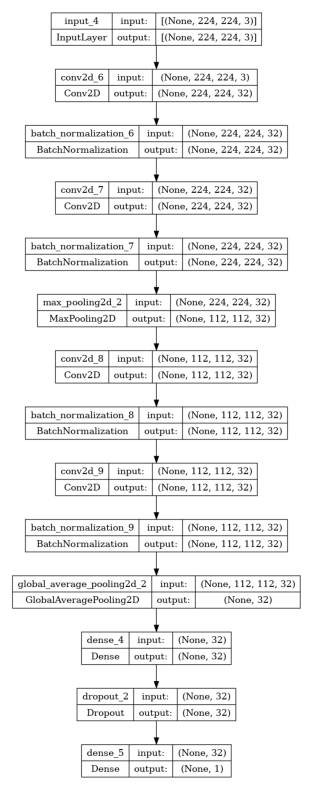

In [56]:
# Generate the model architecture plot
plot_model(model_1, to_file='model_1.png', show_shapes=True, show_layer_names=True)

# Display the image in a notebook cell
image = Image.open('model_1.png')
plt.imshow(image)
plt.axis('off')
plt.show()


# model_2

## Without Pose Estimation key points

In [57]:
## train_generator = train_generator_without_preprocessing
val_generator = val_generator_without_preprocessing
test_generator = test_generator_without_preprocessing
# preprocess_fn = mobilenet_preprocess

neurons_final = 32
# base_model = create_base_MobileNetV2()
# fine_tune_limit = len(base_model.layers) - int(0.1*len(base_model.layers))
model_name= 'model_2'
fine_tuning = 'before_tuning'
keypoints_added = 'without_keypoints'
epochs = 40
lr_1 = 1e-3
lr_2 = 1e-5
print("Done")


Done


In [58]:
#Input shape
input_shape = (224, 224, 3)  # Assuming input images are RGB with size 32x32

# Input Layer
input_layer = Input(shape=input_shape)

# Block 1
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(input_layer)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

# Block 2
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)


# Block 3
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

x = GlobalAveragePooling2D()(x)
x = Dense(neurons_final, activation='relu')(x)
x = Dropout(0.5)(x)

outputs =  Dense(1, activation='sigmoid')(x)
model_2 = Model(input_layer, outputs)
print("Model Summary: " , model_2.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_14 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_14 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_15 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_15 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 32)     0   

In [59]:
call_backs = [EarlyStopping(monitor='val_loss', patience=6),
              ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)]

model_2.compile(optimizer=Adam(learning_rate=lr_1), loss= 'binary_crossentropy', metrics=METRICS)

steps_per_epoch = train_generator.n // batch_size  
validation_steps = val_generator.n // batch_size
print("Training Started\n")   
#############################################################################
history = model_2.fit(train_generator,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    callbacks=call_backs,
                    validation_data=val_generator,
                      class_weight=class_weight
                   )
print("Training Finished\n") 
###############################################################################

Training Started

Epoch 1/40
145/145 [==============================] - 282s 2s/step - loss: 0.9119 - tp: 4160.0000 - fp: 2372.0000 - tn: 2457.0000 - fn: 1444.0000 - accuracy: 0.6342 - precision: 0.6369 - recall: 0.7423 - val_loss: 0.9192 - val_tp: 632.0000 - val_fp: 520.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5486 - val_precision: 0.5486 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/40
145/145 [==============================] - 274s 2s/step - loss: 0.5582 - tp: 4115.0000 - fp: 2123.0000 - tn: 2150.0000 - fn: 884.0000 - accuracy: 0.6757 - precision: 0.6597 - recall: 0.8232 - val_loss: 0.8813 - val_tp: 257.0000 - val_fp: 255.0000 - val_tn: 265.0000 - val_fn: 375.0000 - val_accuracy: 0.4531 - val_precision: 0.5020 - val_recall: 0.4066 - lr: 0.0010
Epoch 3/40
145/145 [==============================] - 270s 2s/step - loss: 0.4363 - tp: 4254.0000 - fp: 1578.0000 - tn: 2759.0000 - fn: 681.0000 - accuracy: 0.7564 - precision: 0.7294 - recall: 0.8620 - val_loss: 0.8461 - v

In [60]:
# delete_folder_contents('/kaggle/working/')

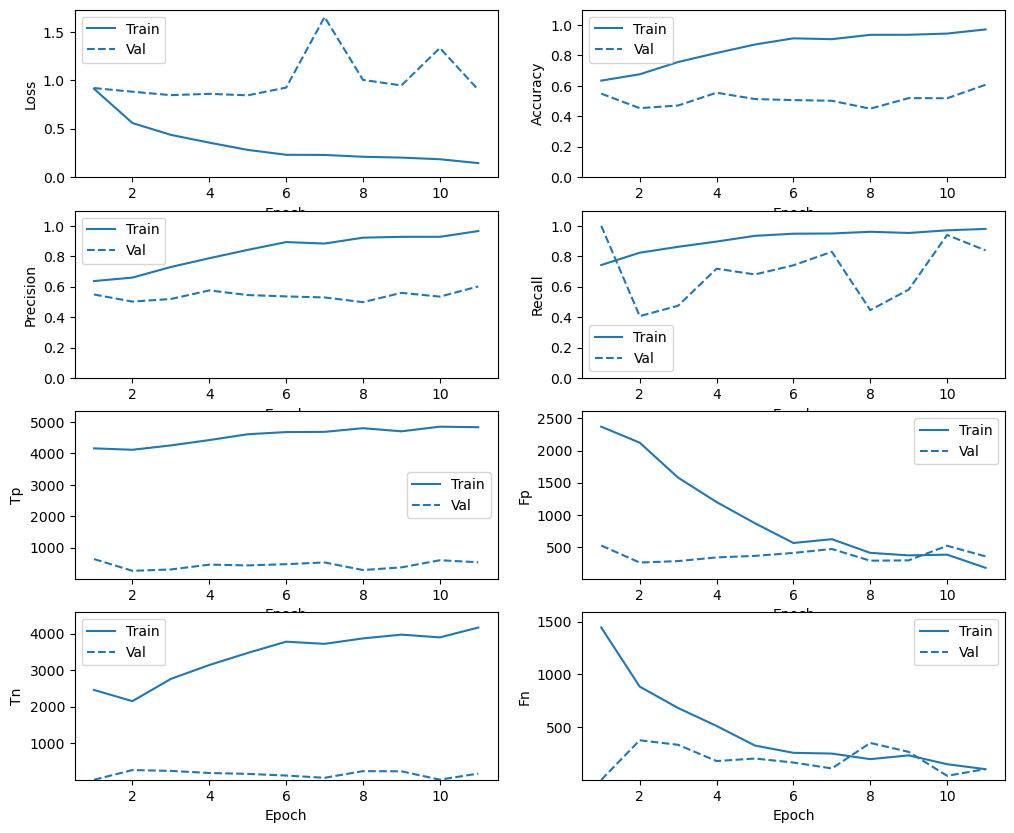

In [61]:
################################################################################################################
plot_save_results(model_2, model_name, fine_tuning, keypoints_added, epochs, batch_size, history, save=False)

# path ='/kaggle/working/{}'.format(model_name)
# name = model_name+'_'+keypoints_added+'_'+fine_tuning+'_'+str(epochs)+'epochs'
# zip_delete(name, path)

#plot_save_results(model,model_name,fine_tuning,keypoints_added,epochs_1,batch_size,history)
# model_4layers.save('/kaggle/working/{}.h5'.format(name))
# saved_model_before_wihoutKPts_path = '/kaggle/working/{}.h5'.format(name)
# print(saved_model_before_wihoutKPts_path)

In [62]:
###########################################################################################################
print("\n\nEvaluation of test Data Generator:\n\n")
# Evaluate the accuracy of the MobileNet_model on the test dataset using the `evaluate` method
test_generator.reset()
model_2.evaluate(test_generator)



Evaluation of test Data Generator:


19/19 [==============================] - 6s 297ms/step - loss: 0.7831 - tp: 572.0000 - fp: 310.0000 - tn: 182.0000 - fn: 97.0000 - accuracy: 0.6494 - precision: 0.6485 - recall: 0.8550


[0.7831301689147949,
 572.0,
 310.0,
 182.0,
 97.0,
 0.6494401097297668,
 0.6485260725021362,
 0.8550074696540833]

## With Pose Estimation key points

In [63]:
train_generator = train_generator_with_preprocessing
val_generator = val_generator_with_preprocessing
test_generator = test_generator_with_preprocessing
# preprocess_fn = mobilenet_preprocess
neurons_final = 32
# base_model = create_base_MobileNetV2()
# fine_tune_limit = len(base_model.layers) - int(0.1 * len(base_model.layers))
model_name= 'my_model_5layers'
fine_tuning = 'before_tuning'
keypoints_added = 'with_keypoints'
epochs = 40
lr_1 = 1e-3
# lr_2 = 1e-5
print("Done")

Done


In [71]:
#Input shape
input_shape = (224, 224, 3)  # Assuming input images are RGB with size 32x32

# Input Layer
input_layer = Input(shape=input_shape)

# Block 1
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(input_layer)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

# Block 2
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

# Block 3
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)

x = GlobalAveragePooling2D()(x)
x = Dense(neurons_final, activation='relu')(x)
x = Dropout(0.5)(x)
outputs =  Dense(1, activation='sigmoid')(x)
model_2_PEK = Model(input_layer, outputs)
print("Model Summary: " , model_2_PEK.summary())


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_24 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_24 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_25 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 112, 112, 32)     0   

In [72]:
call_backs = [ EarlyStopping(monitor='val_loss', patience=6),
               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5) ]

model_2_PEK.compile(optimizer=Adam(learning_rate=lr_1),loss= 'binary_crossentropy',metrics=METRICS)

In [73]:
print(class_weight)

{0: 0.5354541559554413, 1: 0.7771752017284356}


In [74]:
call_backs = [ EarlyStopping(monitor='val_loss', patience=6),
               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5) ]

model_2_PEK.compile(optimizer=Adam(learning_rate=lr_1),loss= 'binary_crossentropy',metrics=METRICS)

# steps_per_epoch = train_generator.n // batch_size  
# validation_steps = val_generator.n // batch_size
print("Training Started\n\n")   
train_generator.reset()
val_generator.reset()
history = model_2_PEK.fit(train_generator,
                    epochs= epochs,
                    callbacks=call_backs,
                    validation_data=val_generator,
                          class_weight=class_weight
                   )
print("Training Finished\n")

Training Started


Epoch 1/40
146/146 [==============================] - 331s 2s/step - loss: 1.1124 - tp: 4930.0000 - fp: 3423.0000 - tn: 1406.0000 - fn: 738.0000 - accuracy: 0.6036 - precision: 0.5902 - recall: 0.8698 - val_loss: 1.0221 - val_tp: 496.0000 - val_fp: 435.0000 - val_tn: 85.0000 - val_fn: 156.0000 - val_accuracy: 0.4957 - val_precision: 0.5328 - val_recall: 0.7607 - lr: 0.0010
Epoch 2/40
146/146 [==============================] - 288s 2s/step - loss: 0.5902 - tp: 4233.0000 - fp: 2209.0000 - tn: 2128.0000 - fn: 766.0000 - accuracy: 0.6813 - precision: 0.6571 - recall: 0.8468 - val_loss: 0.9376 - val_tp: 652.0000 - val_fp: 520.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5563 - val_precision: 0.5563 - val_recall: 1.0000 - lr: 0.0010
Epoch 3/40
146/146 [==============================] - 286s 2s/step - loss: 0.5343 - tp: 3934.0000 - fp: 2529.0000 - tn: 1808.0000 - fn: 1065.0000 - accuracy: 0.6150 - precision: 0.6087 - recall: 0.7870 - val_loss: 0.8770 - v

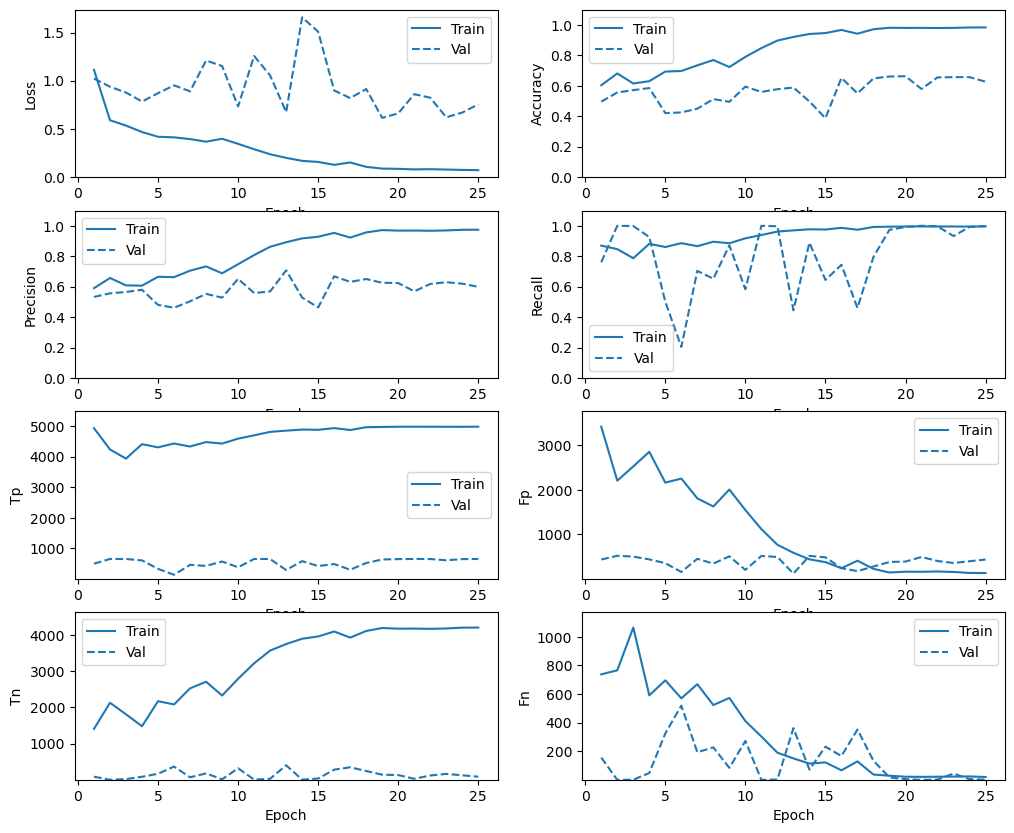

In [75]:
plot_save_results(model_2_PEK, model_name, fine_tuning, keypoints_added, epochs, batch_size, history, save=False)

# path ='/kaggle/working/{}'.format(model_name)
# name = model_name+'_'+keypoints_added+'_'+fine_tuning+'_'+str(epochs)+'epochs'
# zip_delete(name, path)

# #plot_save_results(model,model_name,fine_tuning,keypoints_added,epochs_1,batch_size,history)
# model_4_PEK.save('/kaggle/working/{}.h5'.format(name))

In [76]:
print("\n\nEvaluation of test Data Generator:\n\n")
# Evaluate the accuracy of the MobileNet_model on the test dataset using the `evaluate` method
test_generator.reset()
model_2_PEK.evaluate(test_generator)



Evaluation of test Data Generator:


19/19 [==============================] - 23s 1s/step - loss: 0.7361 - tp: 664.0000 - fp: 411.0000 - tn: 81.0000 - fn: 5.0000 - accuracy: 0.6417 - precision: 0.6177 - recall: 0.9925


[0.7360650300979614,
 664.0,
 411.0,
 81.0,
 5.0,
 0.6416882276535034,
 0.6176744103431702,
 0.9925261735916138]

In [77]:
print("model_2: ")
print(count_conv2d_layers(model_2))
print(count_total_layers(model_2))
print("\n")
print("model_2_PEK: ")
print(count_conv2d_layers(model_2_PEK))
print(count_total_layers(model_2_PEK))

model_2: 
5
17


model_2_PEK: 
5
17


# model_3

## Without Pose Estimation key points

In [20]:
train_generator = train_generator_without_preprocessing
val_generator = val_generator_without_preprocessing
test_generator = test_generator_without_preprocessing
# preprocess_fn = mobilenet_preprocess

neurons_final = 32
# base_model = create_base_MobileNetV2()
# fine_tune_limit = len(base_model.layers) - int(0.1*len(base_model.layers))
model_name= 'my_model'
fine_tuning = 'before_tuning'
keypoints_added = 'without_keypoints'
epochs = 40
lr_1 = 1e-3
lr_2 = 1e-5
print("Done")


Done


In [21]:
#Input shape
input_shape = (224, 224, 3)  # Assuming input images are RGB with size 32x32

# Input Layer
input_layer = Input(shape=input_shape)

# Block 1
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(input_layer)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

# Block 2
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

# Block 3
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)

x = GlobalAveragePooling2D()(x)
x = Dense(neurons_final, activation='relu')(x)
x = Dropout(0.5)(x)
outputs =  Dense(1, activation='sigmoid')(x)
model_3 = Model(input_layer, outputs)
print("Model Summary: " , model_3.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_3 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_4 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 112, 112, 32)     0   

In [22]:
call_backs = [EarlyStopping(monitor='val_loss', patience=6),
              ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)]

model_3.compile(optimizer=Adam(learning_rate=lr_1), loss= 'binary_crossentropy', metrics=METRICS)

steps_per_epoch = train_generator.n // batch_size  
validation_steps = val_generator.n // batch_size
print("Training Started\n")   
#############################################################################
history = model_3.fit(train_generator,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    callbacks=call_backs,
                    validation_data=val_generator,
                      class_weight=class_weight )
print("Training Finished\n") 
###############################################################################

Training Started

Epoch 1/40
145/145 [==============================] - 212s 1s/step - loss: 1.3050 - tp: 3405.0000 - fp: 1700.0000 - tn: 2573.0000 - fn: 1594.0000 - accuracy: 0.6447 - precision: 0.6670 - recall: 0.6811 - val_loss: 1.1704 - val_tp: 632.0000 - val_fp: 520.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5486 - val_precision: 0.5486 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/40
145/145 [==============================] - 140s 965ms/step - loss: 0.6699 - tp: 4195.0000 - fp: 1711.0000 - tn: 2562.0000 - fn: 804.0000 - accuracy: 0.7288 - precision: 0.7103 - recall: 0.8392 - val_loss: 0.9277 - val_tp: 631.0000 - val_fp: 508.0000 - val_tn: 12.0000 - val_fn: 1.0000 - val_accuracy: 0.5582 - val_precision: 0.5540 - val_recall: 0.9984 - lr: 0.0010
Epoch 3/40
145/145 [==============================] - 147s 1s/step - loss: 0.5158 - tp: 4120.0000 - fp: 1666.0000 - tn: 2671.0000 - fn: 815.0000 - accuracy: 0.7324 - precision: 0.7121 - recall: 0.8349 - val_loss: 0.9385 - v

In [23]:
# delete_folder_contents('/kaggle/working/')

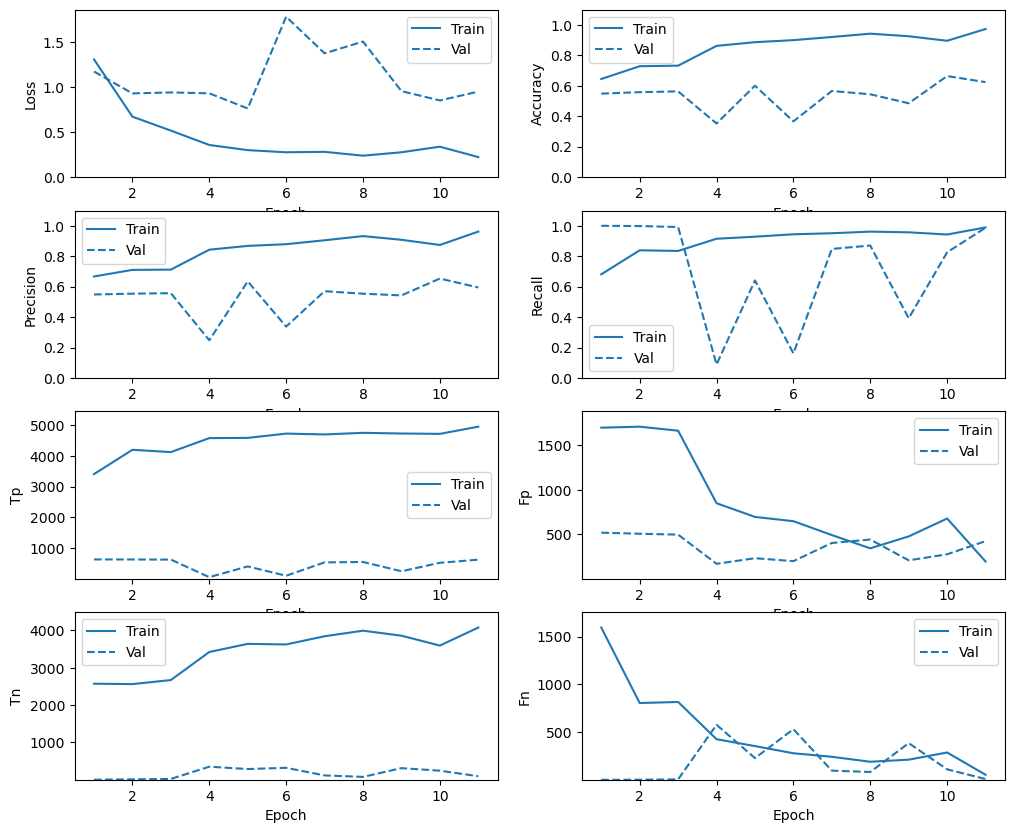

In [24]:
plot_save_results(model_3, model_name, fine_tuning, keypoints_added, epochs, batch_size, history, save=False)

In [25]:
###########################################################################################################
print("\n\nEvaluation of test Data Generator:\n\n")
# Evaluate the accuracy of the MobileNet_model on the test dataset using the `evaluate` method
test_generator.reset()
model_3.evaluate(test_generator)



Evaluation of test Data Generator:


19/19 [==============================] - 12s 638ms/step - loss: 0.9001 - tp: 654.0000 - fp: 392.0000 - tn: 100.0000 - fn: 15.0000 - accuracy: 0.6494 - precision: 0.6252 - recall: 0.9776


[0.900147557258606,
 654.0,
 392.0,
 100.0,
 15.0,
 0.6494401097297668,
 0.6252390146255493,
 0.9775784611701965]

## With Pose Estimation key points

In [26]:
train_generator = train_generator_with_preprocessing
val_generator = val_generator_with_preprocessing
test_generator = test_generator_with_preprocessing
# preprocess_fn = mobilenet_preprocess
neurons_final = 32
# base_model = create_base_MobileNetV2()
# fine_tune_limit = len(base_model.layers) - int(0.1 * len(base_model.layers))
model_name= 'my_model'
fine_tuning = 'before_tuning'
keypoints_added = 'with_keypoints'
epochs = 40
lr_1 = 1e-3
# lr_2 = 1e-5
print("Done")

Done


In [27]:
#Input shape
input_shape = (224, 224, 3)  # Assuming input images are RGB with size 32x32

# Input Layer
input_layer = Input(shape=input_shape)

# Block 1
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(input_layer)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

# Block 2
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)


# Block 3
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)

x = GlobalAveragePooling2D()(x)
x = Dense(neurons_final, activation='relu')(x)
x = Dropout(0.5)(x)
outputs =  Dense(1, activation='sigmoid')(x)

model_3_PEK = Model(input_layer, outputs)
print("Model Summary: " , model_3_PEK.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_9 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_10 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 32)     0   

In [28]:
call_backs = [ EarlyStopping(monitor='val_loss', patience=6),
               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5) ]

model_3_PEK.compile(optimizer=Adam(learning_rate=lr_1),loss= 'binary_crossentropy',metrics=METRICS)

In [29]:
call_backs = [ EarlyStopping(monitor='val_loss', patience=6),
               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5) ]

model_3_PEK.compile(optimizer=Adam(learning_rate=lr_1),loss= 'binary_crossentropy',metrics=METRICS)

# steps_per_epoch = train_generator.n // batch_size  
# validation_steps = val_generator.n // batch_size
print("Training Started\n\n")   
train_generator.reset()
val_generator.reset()
history = model_3_PEK.fit(train_generator, epochs= epochs, callbacks=call_backs, validation_data=val_generator, class_weight=class_weight )
print("Training Finished\n")

Training Started


Epoch 1/40
146/146 [==============================] - 289s 2s/step - loss: 1.2659 - tp: 3907.0000 - fp: 2375.0000 - tn: 2454.0000 - fn: 1761.0000 - accuracy: 0.6060 - precision: 0.6219 - recall: 0.6893 - val_loss: 1.0507 - val_tp: 652.0000 - val_fp: 520.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5563 - val_precision: 0.5563 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/40
146/146 [==============================] - 283s 2s/step - loss: 0.6122 - tp: 4135.0000 - fp: 2406.0000 - tn: 1931.0000 - fn: 864.0000 - accuracy: 0.6497 - precision: 0.6322 - recall: 0.8272 - val_loss: 0.9118 - val_tp: 7.0000 - val_fp: 72.0000 - val_tn: 448.0000 - val_fn: 645.0000 - val_accuracy: 0.3882 - val_precision: 0.0886 - val_recall: 0.0107 - lr: 0.0010
Epoch 3/40
146/146 [==============================] - 296s 2s/step - loss: 0.4689 - tp: 4110.0000 - fp: 1941.0000 - tn: 2396.0000 - fn: 889.0000 - accuracy: 0.6969 - precision: 0.6792 - recall: 0.8222 - val_loss: 0.7758 - val

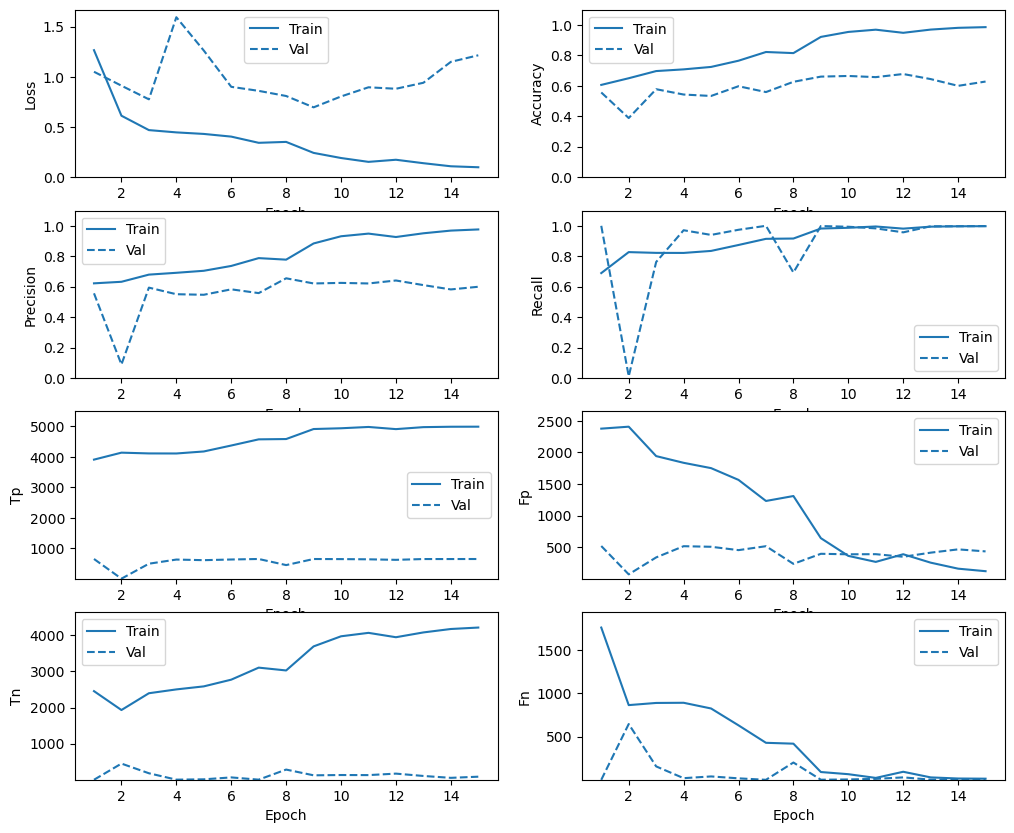

In [30]:
plot_save_results(model_3_PEK, model_name, fine_tuning, keypoints_added, epochs, batch_size, history, save=False)

In [31]:
print("\n\nEvaluation of test Data Generator:\n\n")
# Evaluate the accuracy of the MobileNet_model on the test dataset using the `evaluate` method
test_generator.reset()
model_3_PEK.evaluate(test_generator)



Evaluation of test Data Generator:


19/19 [==============================] - 22s 1s/step - loss: 1.2113 - tp: 661.0000 - fp: 400.0000 - tn: 92.0000 - fn: 8.0000 - accuracy: 0.6486 - precision: 0.6230 - recall: 0.9880


[1.2113275527954102,
 661.0,
 400.0,
 92.0,
 8.0,
 0.6485788226127625,
 0.6229971647262573,
 0.988041877746582]

In [32]:
print("model_3: ")
print(count_conv2d_layers(model_3))
print(count_total_layers(model_3))
print("\n")
print("model_3_PEK: ")
print(count_conv2d_layers(model_3_PEK))
print(count_total_layers(model_3_PEK))

model_3: 
6
19


model_3_PEK: 
6
19


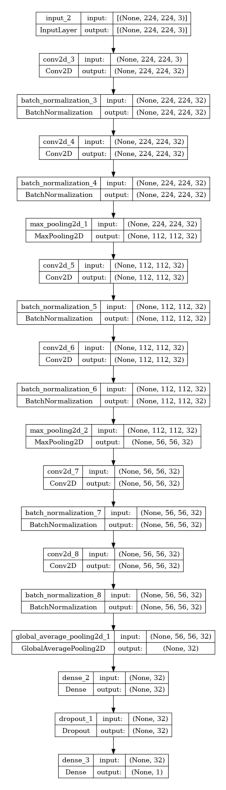

In [33]:
# Generate the model architecture plot
plot_model(model_3, to_file='model_3.png', show_shapes=True, show_layer_names=True)

# Display the image in a notebook cell
image = Image.open('model_3.png')
plt.imshow(image)
plt.axis('off')
plt.show()

# model_4

## Without Pose Estimation key points

In [34]:
train_generator = train_generator_without_preprocessing
val_generator = val_generator_without_preprocessing
test_generator = test_generator_without_preprocessing
# preprocess_fn = mobilenet_preprocess

neurons_final = 32
# base_model = create_base_MobileNetV2()
# fine_tune_limit = len(base_model.layers) - int(0.1*len(base_model.layers))
model_name= 'my_model'
fine_tuning = 'before_tuning'
keypoints_added = 'without_keypoints'
epochs = 40
lr_1 = 1e-3
lr_2 = 1e-5
print("Done")


Done


In [35]:
#Input shape
input_shape = (224, 224, 3)  # Assuming input images are RGB with size 32x32

# Input Layer
input_layer = Input(shape=input_shape)

# Block 1
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(input_layer)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

# Block 2
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)


# Block 3
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)


#Block 4 
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

x = GlobalAveragePooling2D()(x)
x = Dense(neurons_final, activation='relu')(x)
x = Dropout(0.5)(x)
outputs =  Dense(1, activation='sigmoid')(x)
model_4 = Model(input_layer, outputs)
print("Model Summary: " , model_4.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_15 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_16 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 32)     0   

In [36]:
call_backs = [EarlyStopping(monitor='val_loss', patience=6),
              ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)]

model_4.compile(optimizer=Adam(learning_rate=lr_1), loss= 'binary_crossentropy', metrics=METRICS)

steps_per_epoch = train_generator.n // batch_size  
validation_steps = val_generator.n // batch_size
print("Training Started\n")   
#############################################################################
history = model_4.fit(train_generator,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    callbacks=call_backs,
                    validation_data=val_generator,
                      class_weight=class_weight )
print("Training Finished\n") 
###############################################################################

Training Started

Epoch 1/40
145/145 [==============================] - 147s 963ms/step - loss: 1.3461 - tp: 4622.0000 - fp: 3029.0000 - tn: 1736.0000 - fn: 1046.0000 - accuracy: 0.6094 - precision: 0.6041 - recall: 0.8155 - val_loss: 1.1885 - val_tp: 5.0000 - val_fp: 121.0000 - val_tn: 399.0000 - val_fn: 627.0000 - val_accuracy: 0.3507 - val_precision: 0.0397 - val_recall: 0.0079 - lr: 0.0010
Epoch 2/40
145/145 [==============================] - 141s 973ms/step - loss: 0.6874 - tp: 4227.0000 - fp: 1812.0000 - tn: 2461.0000 - fn: 772.0000 - accuracy: 0.7213 - precision: 0.7000 - recall: 0.8456 - val_loss: 0.9516 - val_tp: 631.0000 - val_fp: 489.0000 - val_tn: 31.0000 - val_fn: 1.0000 - val_accuracy: 0.5747 - val_precision: 0.5634 - val_recall: 0.9984 - lr: 0.0010
Epoch 3/40
145/145 [==============================] - 140s 963ms/step - loss: 0.4852 - tp: 4442.0000 - fp: 1571.0000 - tn: 2702.0000 - fn: 557.0000 - accuracy: 0.7705 - precision: 0.7387 - recall: 0.8886 - val_loss: 1.2197 - v

In [37]:
# delete_folder_contents('/kaggle/working/')

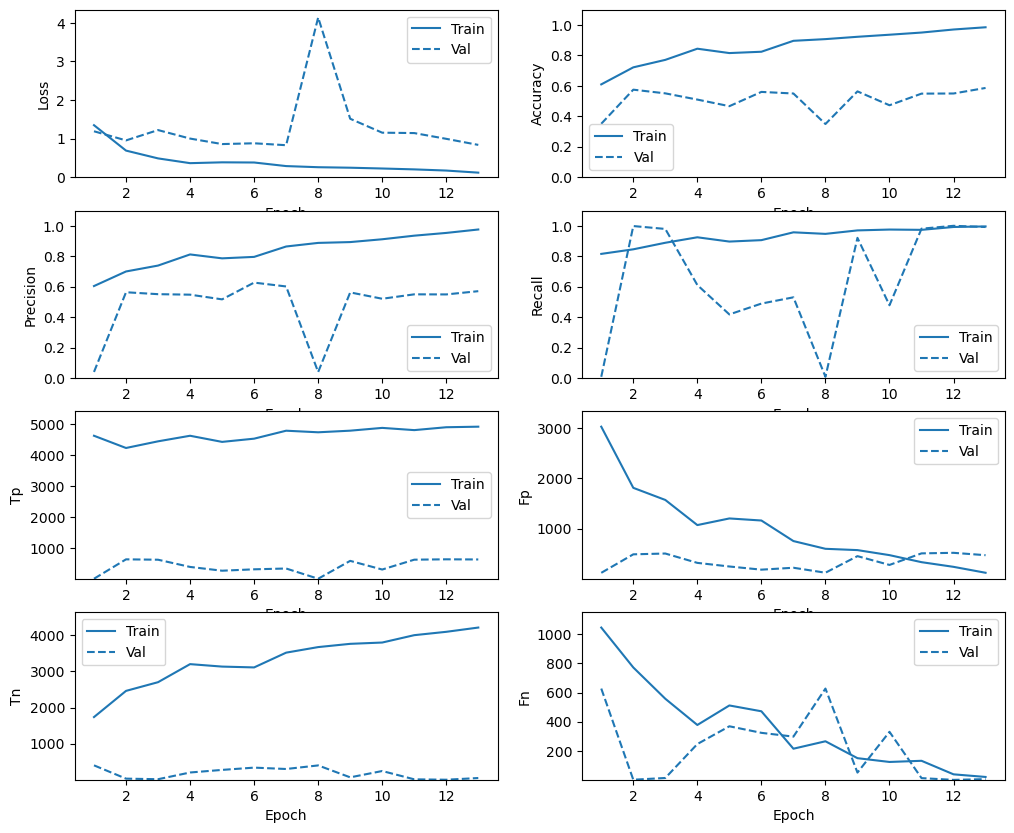

In [38]:
################################################################################################################
plot_save_results(model_4, model_name, fine_tuning, keypoints_added, epochs, batch_size, history, save=False)

In [39]:
###########################################################################################################
print("\n\nEvaluation of test Data Generator:\n\n")
# Evaluate the accuracy of the MobileNet_model on the test dataset using the `evaluate` method
test_generator.reset()
model_4.evaluate(test_generator)



Evaluation of test Data Generator:


19/19 [==============================] - 5s 275ms/step - loss: 0.7842 - tp: 653.0000 - fp: 439.0000 - tn: 53.0000 - fn: 16.0000 - accuracy: 0.6081 - precision: 0.5980 - recall: 0.9761


[0.7841875553131104,
 653.0,
 439.0,
 53.0,
 16.0,
 0.6080964803695679,
 0.5979853272438049,
 0.9760836958885193]

## With Pose Estimation key points

In [40]:
train_generator = train_generator_with_preprocessing
val_generator = val_generator_with_preprocessing
test_generator = test_generator_with_preprocessing
# preprocess_fn = mobilenet_preprocess
neurons_final = 32
# base_model = create_base_MobileNetV2()
# fine_tune_limit = len(base_model.layers) - int(0.1 * len(base_model.layers))
model_name= 'my_model'
fine_tuning = 'before_tuning'
keypoints_added = 'with_keypoints'
epochs = 40
lr_1 = 1e-3
# lr_2 = 1e-5
print("Done")

Done


In [41]:
#Input shape
input_shape = (224, 224, 3)  # Assuming input images are RGB with size 32x32

# Input Layer
input_layer = Input(shape=input_shape)

# Block 1
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(input_layer)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

# Block 2
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

# Block 3
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

#Block 4 
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

x = GlobalAveragePooling2D()(x)
x = Dense(neurons_final, activation='relu')(x)
x = Dropout(0.5)(x)
outputs =  Dense(1, activation='sigmoid')(x)
model_4_PEK = Model(input_layer, outputs)
print("Model Summary: " , model_4_PEK.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_22 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_22 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_23 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_23 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 112, 112, 32)     0   

In [42]:
call_backs = [ EarlyStopping(monitor='val_loss', patience=6),
               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5) ]

model_3_PEK.compile(optimizer=Adam(learning_rate=lr_1),loss= 'binary_crossentropy',metrics=METRICS)

In [43]:
call_backs = [ EarlyStopping(monitor='val_loss', patience=6),
               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5) ]

model_4_PEK.compile(optimizer=Adam(learning_rate=lr_1),loss= 'binary_crossentropy',metrics=METRICS)

# steps_per_epoch = train_generator.n // batch_size  
# validation_steps = val_generator.n // batch_size
print("Training Started\n\n")   
train_generator.reset()
val_generator.reset()
history = model_4_PEK.fit(train_generator, epochs= epochs, callbacks=call_backs, validation_data=val_generator, class_weight=class_weight )
print("Training Finished\n")

Training Started


Epoch 1/40
146/146 [==============================] - 293s 2s/step - loss: 1.2231 - tp: 4283.0000 - fp: 2722.0000 - tn: 2107.0000 - fn: 1385.0000 - accuracy: 0.6087 - precision: 0.6114 - recall: 0.7556 - val_loss: 1.0095 - val_tp: 652.0000 - val_fp: 520.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5563 - val_precision: 0.5563 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/40
146/146 [==============================] - 290s 2s/step - loss: 0.5720 - tp: 4240.0000 - fp: 1988.0000 - tn: 2349.0000 - fn: 759.0000 - accuracy: 0.7058 - precision: 0.6808 - recall: 0.8482 - val_loss: 0.8534 - val_tp: 245.0000 - val_fp: 294.0000 - val_tn: 226.0000 - val_fn: 407.0000 - val_accuracy: 0.4019 - val_precision: 0.4545 - val_recall: 0.3758 - lr: 0.0010
Epoch 3/40
146/146 [==============================] - 287s 2s/step - loss: 0.4441 - tp: 4388.0000 - fp: 1842.0000 - tn: 2495.0000 - fn: 611.0000 - accuracy: 0.7373 - precision: 0.7043 - recall: 0.8778 - val_loss: 0.8283 - 

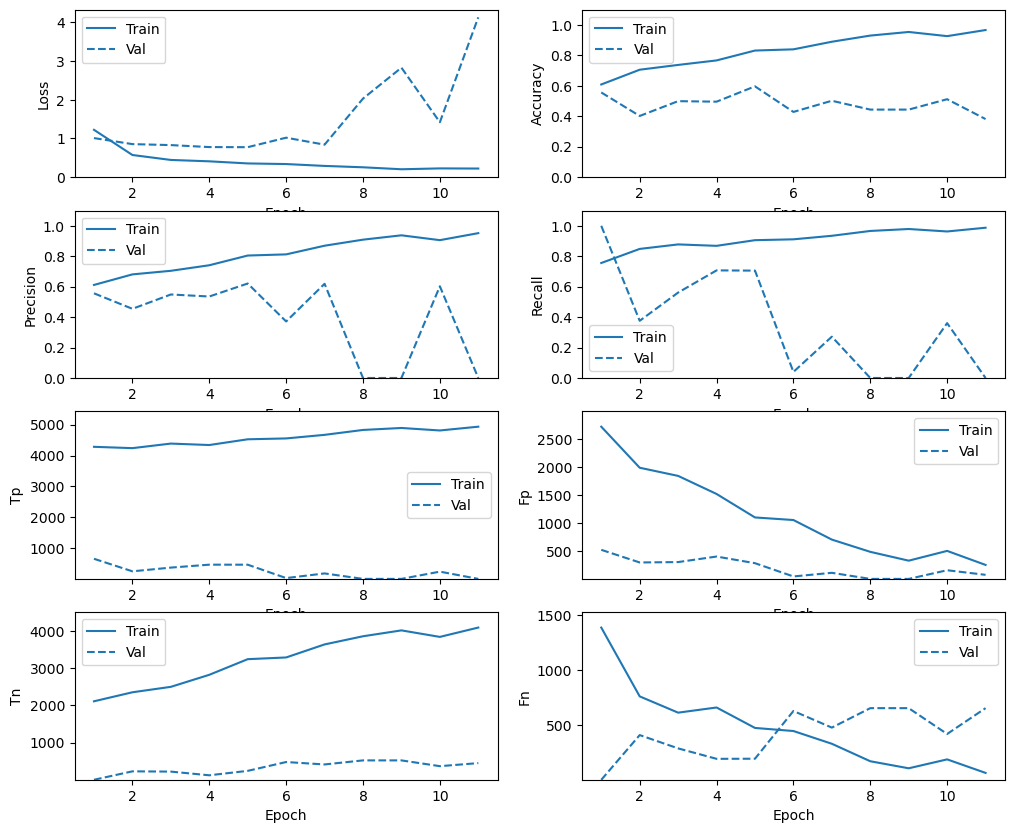

In [44]:
plot_save_results(model_4_PEK, model_name, fine_tuning, keypoints_added, epochs, batch_size, history, save=False)

In [45]:
print("\n\nEvaluation of test Data Generator:\n\n")
# Evaluate the accuracy of the MobileNet_model on the test dataset using the `evaluate` method
test_generator.reset()
model_4_PEK.evaluate(test_generator)



Evaluation of test Data Generator:


19/19 [==============================] - 22s 1s/step - loss: 4.2839 - tp: 0.0000e+00 - fp: 79.0000 - tn: 413.0000 - fn: 669.0000 - accuracy: 0.3557 - precision: 0.0000e+00 - recall: 0.0000e+00


[4.283935070037842, 0.0, 79.0, 413.0, 669.0, 0.35572782158851624, 0.0, 0.0]

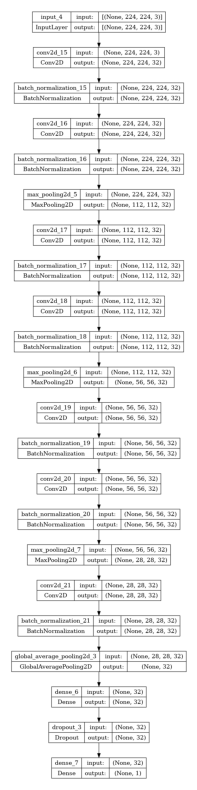

In [46]:
# Generate the model architecture plot
plot_model(model_4, to_file='model_4.png', show_shapes=True, show_layer_names=True)

# Display the image in a notebook cell
image = Image.open('model_4.png')
plt.imshow(image)
plt.axis('off')
plt.show()

In [47]:
print("model_4: ")
print(count_conv2d_layers(model_4))
print(count_total_layers(model_4))
print("\n")
print("model_4_PEK: ")
print(count_conv2d_layers(model_4_PEK))
print(count_total_layers(model_4_PEK))

model_4: 
7
22


model_4_PEK: 
7
22


In [48]:
print("Finish training.")

Finish training.


In [49]:
print("Done ")

Done 
